## Analysis problem
The dataset that we want to analyze in this project is about number of deaths for viral hepatitis and sequelae of viral hepatitis in 25 European countries. Our dataset is divided into two files:
 - one contains the total amount of deaths for all causes of death from 2001 to 2010
 - the other contains the number of deaths for viral hepatitis and sequelae of viral hepatitis from 2001 to 2010

The data in the first file will be used as normalization factor for the number of deaths for viral hepatitis. Therefore, the data that will be analyzed is the ratio of deaths for viral hepatitis over the total number of deaths in that country.
Our objective for this analysis is to predict for each country the number of deaths for viral hepatitis in the following years. We decided not to make any prediction for a country outside the list because, even if there could be a hyperdistribution which the parameters of our models could follow, we considered that there could be too many differences among the countries which would make such a prediction unreliable.

## Model description
As first choice we will assess the use of a Separate model. We will consider each country as a separate group, and so we will have a distribution that describe each of them independently. 

![Separate Model](./separate.png)

We will also evaluate a Hierarchial model, in order to verify that our initial assumption about the independece of the distribution of each country is correct. In other words, we expect that the hierarchial model will perform worse than the Separate model, which is our first choice.

![Hierarchial Model](./hierarchial.png)

## Prior choices
Our prior hypothesis are the followings:
 - we assume that the data for each  distributed $y_{ij}\mid\theta_j \sim \mathcal{N}(\mu_ {ij}, \sigma_j)$
 - as prior distribution we will use an uninformative flat prior $\theta_j \sim \mathcal{U}([0,1])=Beta(1,1)$

In the Separate model we will fit a linear gaussian model for each group independently:
$$\mu_{ij} = \alpha_j + \beta_j x_{ij}$$
and then for the Hierarchial model we will add the layer represented by the hyperdistributions for $\alpha$, $\beta$ and $\sigma$:
$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\sigma \sim Inv-\chi^2(\sigma^2_0, \nu_0)$$


In [2]:
import pystan
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import stan_utility
import matplotlib as mpl
import psis

d = pd.read_csv("../dataset/deads.txt", sep=" ", header=None, skiprows=1)
h = pd.read_csv("../dataset/hepatitis.txt", sep=" ", header=None, skiprows=1)
countries = d[0].as_matrix()
d = d.iloc[:, 1:d.shape[1]].as_matrix()
h = h.iloc[:, 1:h.shape[1]].as_matrix()

data = h/d

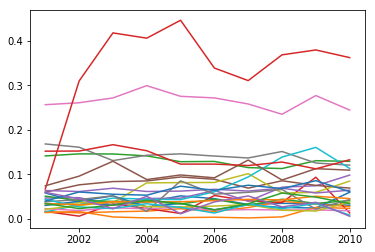

In [8]:
for i in range(25):
    plt.plot(range(2001, 2011), data[i]*100)
plt.show()

# Separate model

In [9]:
separate_model_code = '''
data {
    int<lower=0> N;
    vector[N] x; // group indicator
    vector[N] y;
    real xpred;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    ypred = normal_rng(alpha + beta*xpred, sigma);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}
'''

sm = stan_utility.compile_model_plus(separate_model_code)

Using cached StanModel


In [ ]:
N = 10
x = range(2001, 2011)
xpred=2011
K = 25 

samples = []
for i in range(K):
    y = np.log(data[i]).ravel()   # observations
    separate_model_data = dict(
        N = N,
        #K = K,  # 25 contries
        x = x,  # group indicators
        y = y,  # observations
        xpred=xpred
    )

    samples.append(sm.sampling(n_jobs=4, data=separate_model_data, control=dict(adapt_delta=0.95, max_treedepth=20)))

    print('Completed: group ', i)
print('Completed: separate model')

Completed: group  0


# Hierarchical

In [3]:
hierarchical_model_code = '''
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
  int xpred;
}
parameters {
  vector[K] alpha;        // group means
  real mu_alpha;
  real sigma_alpha;
  
  vector[K] beta;        // group means
  real mu_beta;
  real sigma_beta;
  
  real<lower=0> sigma[K]; 
  real nu_0;
  real sigma_0;
}

transformed parameters {
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[x[i]] + beta[x[i]]*x[i];
}

model {
    sigma ~ half-cauchy(mode, scale)

    alpha ~ normal(mu_alpha, sigma_alpha);
    beta ~ normal(mu_beta, sigma_beta);
    sigma ~ scaled_inv_chi_square(sigma_0, nu_0);
    
    y ~ normal(mu, sigma[x]);
}

generated quantities{
    real ypred[K];
    vector[N] log_lik;
    
    for (i in 1:K)
    {
        ypred[i] = normal_rng(alpha[i] + beta[i]*xpred, sigma[i]);
    }
    
    for (i in 1:N)
    {
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[x[i]]);
    }
}
'''

sm_hierarchical = stan_utility.compile_model_plus(hierarchical_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f33a8b74a230c2fdd82c5bbc279eeecb NOW.


In [4]:
K=25
nj = 10
N = nj*K
x = np.array([i for i in range(1,K+1) for j in range(10)])
# print(x)
y = np.log(data[0:K]).ravel()  # observations
xpred=K+1

hierarchical_model_data = dict(
    N = N,
    K = K,  # 25 contries
    x = x,  # group indicators
    y = y,  # observations
    xpred=xpred
)

samples_hierarchical = sm_hierarchical.sampling(n_jobs=-1, data=hierarchical_model_data)

print('Completed - hierarchical model')

Completed - hierarchical model


## How Stan model is run

### Separate
Given that we are using a separate model, we created a Stan model which is run once on the data of each country. This gives us K predictions, one for each analysed country.

### Hierarchical
In the hierarchical model we created a single Stan model to analyse the whole dataset at one, considering each parameter `alpha` (respectively `beta`) to be following a common hyperdistribution across all the countries. 

In [ ]:
plt.hist(np.exp(samples['ypred']), 50)
plt.xlabel('y-prediction for x={}'.format(2011))
plt.show()

In [ ]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1

color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)

plt.fill_between(
    x[0],
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)

plt.plot(
    x[0],
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)

plt.scatter(x[0], y, 5, color=color_scatter)
plt.xlim((2001, 2010))
plt.tight_layout()
plt.show()

## Convergence analysis
### Separate model

In [24]:
for convergence in samples:
    print(convergence)

Inference for Stan model: anon_model_570544391b1e440e4aa07d2bfc218092.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       70.84    1.81  53.64 -35.16  38.79  70.16 103.43 179.22    875   1.01
beta        -0.04  9.0e-4   0.03  -0.09  -0.06  -0.04  -0.02   0.01    875   1.01
sigma        0.25  3.1e-3   0.09   0.14   0.19   0.23   0.28   0.44    751    1.0
mu[0]        -7.7  4.4e-3   0.15  -7.98  -7.79   -7.7  -7.61   -7.4   1078    1.0
mu[1]       -7.74  3.6e-3   0.12  -7.98  -7.82  -7.74  -7.66  -7.48   1200    1.0
mu[2]       -7.78  2.8e-3   0.11  -7.99  -7.84  -7.78  -7.72  -7.56   1447    1.0
mu[3]       -7.82  2.0e-3   0.09   -8.0  -7.87  -7.82  -7.76  -7.64   2001    1.0
mu[4]       -7.86  1.4e-3   0.08  -8.03  -7.91  -7.86  -7.81  -7.69   3598    1.0
mu[5]        -7.9  1.4e-3   0.08  -8.06  -7.95   -7.9  -7.85  -7.74   362

Inference for Stan model: anon_model_570544391b1e440e4aa07d2bfc218092.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        9.78    0.76  20.21 -31.27  -2.25    9.7   21.7  52.05    708    1.0
beta      -7.8e-3  3.8e-4   0.01  -0.03  -0.01-7.8e-3-1.8e-3   0.01    708    1.0
sigma        0.08  9.0e-4   0.03   0.05   0.07   0.08    0.1   0.15    846    1.0
mu[0]        -5.9  1.7e-3   0.05  -6.01  -5.93   -5.9  -5.87  -5.79    953    1.0
mu[1]       -5.91  1.3e-3   0.04   -6.0  -5.94  -5.91  -5.88  -5.82   1091    1.0
mu[2]       -5.92  1.0e-3   0.04  -5.99  -5.94  -5.92  -5.89  -5.84   1380    1.0
mu[3]       -5.92  6.8e-4   0.03  -5.99  -5.94  -5.92   -5.9  -5.86   2142    1.0
mu[4]       -5.93  4.9e-4   0.03  -5.99  -5.95  -5.93  -5.91  -5.88   3336    1.0
mu[5]       -5.94  5.0e-4   0.03   -6.0  -5.96  -5.94  -5.92  -5.88   318

Inference for Stan model: anon_model_570544391b1e440e4aa07d2bfc218092.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       29.23    1.69  42.44  -51.2   3.59  29.07  54.79 115.83    628   1.01
beta        -0.02  8.4e-4   0.02  -0.06  -0.03  -0.02-5.7e-3   0.02    628   1.01
sigma        0.18  2.2e-3   0.06   0.11   0.14   0.17    0.2   0.35    747    1.0
mu[0]       -7.77  3.7e-3   0.11  -7.99  -7.83  -7.77   -7.7  -7.53    938   1.01
mu[1]       -7.78  3.0e-3    0.1  -7.97  -7.84  -7.78  -7.73  -7.59   1049   1.01
mu[2]        -7.8  2.3e-3   0.08  -7.96  -7.85   -7.8  -7.76  -7.64   1279   1.01
mu[3]       -7.82  1.5e-3   0.07  -7.95  -7.86  -7.82  -7.78  -7.69   2064    1.0
mu[4]       -7.84  1.1e-3   0.06  -7.96  -7.88  -7.84   -7.8  -7.72   3203    1.0
mu[5]       -7.86  1.0e-3   0.06  -7.98  -7.89  -7.86  -7.82  -7.74   374

Inference for Stan model: anon_model_570544391b1e440e4aa07d2bfc218092.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       10.91    2.66  81.67 -154.4 -38.03   9.68  63.69 173.75    946    1.0
beta      -9.5e-3  1.3e-3   0.04  -0.09  -0.04-9.0e-3   0.01   0.07    946    1.0
sigma        0.34  3.4e-3    0.1   0.21   0.27   0.32   0.39    0.6    932    1.0
mu[0]       -8.19  6.4e-3   0.22  -8.63  -8.32  -8.19  -8.05  -7.76   1141    1.0
mu[1]        -8.2  5.1e-3   0.18  -8.57  -8.31   -8.2  -8.08  -7.84   1257    1.0
mu[2]       -8.21  3.9e-3   0.15  -8.52   -8.3  -8.21  -8.11  -7.91   1493    1.0
mu[3]       -8.22  2.8e-3   0.13  -8.48  -8.29  -8.22  -8.14  -7.97   2034    1.0
mu[4]       -8.23  1.9e-3   0.11  -8.46  -8.29  -8.23  -8.16   -8.0   3469    1.0
mu[5]       -8.24  1.8e-3   0.11  -8.46  -8.31  -8.23  -8.17  -8.01   368

Inference for Stan model: anon_model_570544391b1e440e4aa07d2bfc218092.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      252.91    6.12 190.16 -141.9  138.9 258.22 368.68 627.66    965    1.0
beta        -0.13  3.1e-3   0.09  -0.32  -0.19  -0.13  -0.07   0.07    965    1.0
sigma        0.85  8.7e-3   0.26    0.5   0.66    0.8   0.97   1.46    895    1.0
mu[0]       -7.59    0.01   0.52  -8.62  -7.91  -7.59  -7.28  -6.54   1307    1.0
mu[1]       -7.72    0.01   0.44  -8.61   -8.0  -7.72  -7.45   -6.8   1474    1.0
mu[2]       -7.85  8.8e-3   0.37  -8.61  -8.09  -7.85  -7.63  -7.06   1797    1.0
mu[3]       -7.98  6.5e-3   0.32  -8.65  -8.18  -7.98  -7.79   -7.3   2463    1.0
mu[4]       -8.11  5.0e-3   0.29  -8.72  -8.29  -8.11  -7.93   -7.5   3499    1.0
mu[5]       -8.24  5.0e-3   0.29  -8.85  -8.42  -8.24  -8.07  -7.62   343

In [25]:
for convergence in samples:
    stan_utility.check_div(convergence)

7.0 of 4000 iterations ended with a divergence (0.175%)
Try running with larger adapt_delta to remove the divergences
2.0 of 4000 iterations ended with a divergence (0.05%)
Try running with larger adapt_delta to remove the divergences
87.0 of 4000 iterations ended with a divergence (2.175%)
Try running with larger adapt_delta to remove the divergences
54.0 of 4000 iterations ended with a divergence (1.35%)
Try running with larger adapt_delta to remove the divergences
6.0 of 4000 iterations ended with a divergence (0.15%)
Try running with larger adapt_delta to remove the divergences
7.0 of 4000 iterations ended with a divergence (0.175%)
Try running with larger adapt_delta to remove the divergences
0.0 of 4000 iterations ended with a divergence (0.0%)
25.0 of 4000 iterations ended with a divergence (0.625%)
Try running with larger adapt_delta to remove the divergences
0.0 of 4000 iterations ended with a divergence (0.0%)
216.0 of 4000 iterations ended with a divergence (5.4%)
Try runnin

In [26]:
for convergence in samples:
    stan_utility.check_treedepth(convergence)

567 of 4000 iterations saturated the maximum tree depth of 10 (14.175%)
Run again with max_depth set to a larger value to avoid saturation
536 of 4000 iterations saturated the maximum tree depth of 10 (13.4%)
Run again with max_depth set to a larger value to avoid saturation
700 of 4000 iterations saturated the maximum tree depth of 10 (17.5%)
Run again with max_depth set to a larger value to avoid saturation
576 of 4000 iterations saturated the maximum tree depth of 10 (14.4%)
Run again with max_depth set to a larger value to avoid saturation
550 of 4000 iterations saturated the maximum tree depth of 10 (13.75%)
Run again with max_depth set to a larger value to avoid saturation
500 of 4000 iterations saturated the maximum tree depth of 10 (12.5%)
Run again with max_depth set to a larger value to avoid saturation
584 of 4000 iterations saturated the maximum tree depth of 10 (14.6%)
Run again with max_depth set to a larger value to avoid saturation
615 of 4000 iterations saturated the m

For every model separately we have that each value of $\widehat{R}$ is very close to 1.0 and in any case under 1.1, therefore we can say that each model has converged.

### Hierarchical Model

In [5]:
samples_hierarchical

Inference for Stan model: anon_model_f33a8b74a230c2fdd82c5bbc279eeecb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]      -7.86  2.9e-3   0.09  -8.05  -7.92  -7.86   -7.8  -7.68    996   1.01
alpha[1]      -8.42  5.5e-3   0.15  -8.73  -8.52  -8.42  -8.32  -8.12    758   1.01
alpha[2]      -6.62  7.6e-3   0.14  -6.93  -6.69  -6.61  -6.53  -6.36    338   1.02
alpha[3]      -8.19    0.01   0.31  -8.78   -8.4   -8.2   -8.0  -7.56    631   1.01
alpha[4]      -7.49    0.01   0.24  -7.98  -7.63  -7.48  -7.34  -7.02    466   1.01
alpha[5]      -7.12    0.02   0.26   -7.7  -7.26   -7.1  -6.95  -6.63    288   1.02
alpha[6]      -5.97    0.02   0.35  -6.83  -6.12  -5.93  -5.74  -5.39    241   1.02
alpha[7]      -6.56    0.02   0.35  -7.37  -6.75  -6.53  -6.32  -5.94    288   1.03
alpha[8]      -7.34    0.02   0.39  -8.16  -7.57  -7.33

For the hierarchical model we have that each value for $\widehat{R}$ is very close to 1.0 and in any case under 1.10 . Therefors, we can say that the model is converging.

## Posterior predictive checking

### Separate Model
In order to check how well the different models are fitting the data, we will use leave-one-out (LOO) cross validation method. In particular, we will use PSIS-LOO (Pareto smoothed importance sampling LOO) code for computing approximate LOO-CV. 

Effective number of parameteres:  59.5482042314
-------------------------------------
Group  0
K values > 0.7: 1
K values > 0.5: 1
p_eff for group  0 :  2.08025049099
p_eff avg:  2.38192816926
-------------------------------------
Group  1
K values > 0.7: 0
K values > 0.5: 3
p_eff for group  1 :  2.45018378005
p_eff avg:  2.38192816926
-------------------------------------
Group  2
K values > 0.7: 0
K values > 0.5: 1
p_eff for group  2 :  2.22291210158
p_eff avg:  2.38192816926
-------------------------------------
Group  3
K values > 0.7: 1
K values > 0.5: 2
p_eff for group  3 :  2.7532234454
p_eff avg:  2.38192816926
-------------------------------------
Group  4
K values > 0.7: 1
K values > 0.5: 1
p_eff for group  4 :  2.32660434164
p_eff avg:  2.38192816926
-------------------------------------
Group  5
K values > 0.7: 0
K values > 0.5: 2
p_eff for group  5 :  2.34123855658
p_eff avg:  2.38192816926
-------------------------------------
Group  6
K values > 0.7: 0
K values > 0.5: 4


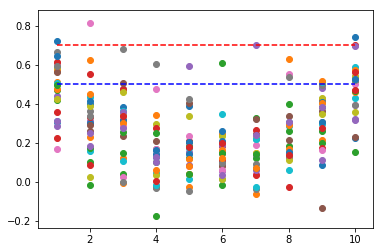

In [12]:
S = samples[0]["log_lik"].shape[0]

log_lik_sep = samples[0]["log_lik"].T
for sample in samples[1:]:
    log_lik = sample["log_lik"].T
    log_lik_sep = np.concatenate((log_lik_sep,log_lik))
log_lik_sep = log_lik_sep.T

loo_sep ,loos_sep, ks_sep = psis.psisloo(log_lik_sep)
lppd_sep = np.sum(np.log(np.mean(np.exp(log_lik_sep), axis = 0)))
p_eff_sep = lppd_sep - loo_sep
print("Effective number of parameteres: ", p_eff_sep)

ks_sep_matrix = ks_sep.reshape((25,10))

for i, sample in enumerate(samples):
    log_lik_i = sample["log_lik"]
    loo_sep_i ,loos_sep_i, ks_sep_i = psis.psisloo(log_lik_i)
    lppd_sep_i = np.sum(np.log(np.mean(np.exp(log_lik_i), axis = 0)))
    p_eff_sep_i = lppd_sep_i - loo_sep_i
    print("-------------------------------------")
    print("Group ", i)
    print("K values > 0.7: {}".format(np.sum(ks_sep_i>=0.7)))
    print("K values > 0.5: {}".format(np.sum(ks_sep_i>0.5)))
    #print("Agg K values > 0.7: {}".format(np.sum(ks_sep_matrix[i]>=0.7)))
    #print("Agg K values > 0.5: {}".format(np.sum(ks_sep_matrix[i]>0.5)))
    print("p_eff for group ", i, ": ", p_eff_sep_i)
    print("p_eff avg: ", p_eff_sep/25)

for i in range(25):
    plt.scatter(range(1,11), ks_sep_matrix[i])
plt.plot(range(1,11), [0.5 for i in range(1,11)], "b--")
plt.plot(range(1,11), [0.7 for i in range(1,11)], "r--")
plt.show()


The results show that the number of effective estimated parameters for the model of each country is close to 3 for most of them, with some exceptions going as low as 2 and as high as 4. On average the number of effective estimated parameters approaces 3 as well. That is what we expected, since each model depends on three parameters: $\alpha$, $\beta$ and $\sigma$.

Accordingly, most of the models had appropriate k values. Anyway, in some of them we have that some values are over 0.5 and so in these cases the $p_{eff}$ values are biased.

### Hierarchical Model

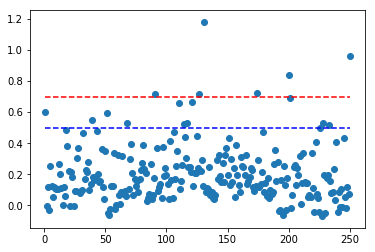

In [16]:
log_lik_hier = samples_hierarchical["log_lik"]

loo_hier ,loos_hier, ks_hier = psis.psisloo(log_lik_hier)
lppd_hier = np.sum(np.log(np.mean(np.exp(log_lik_hier), axis = 0)))
p_eff_hier = lppd_hier - loo_hier

plt.scatter(range(1,251), ks_hier)
plt.plot(range(1,251), [0.5 for i in range(1,251)], "b--")
plt.plot(range(1,251), [0.7 for i in range(1,251)], "r--")
plt.show()

## Model Comparison

We want now to compare the predictive performance of the two models that we used in the previous sections.
In order to do so we will use the produced PSIS-LOO values for both models:

In [13]:
print("Separate model: ", loo_sep, p_eff_sep)
print("Hierarchical model: ", loo_hier, p_eff_hier)

Separate model:  -31.6342288342 59.5482042314
Hierarchical model:  -58.4242965886 44.1347337955
